In [1]:
#from google.colab import drive
#drive.mount('/content/drive')

In [3]:
#!pip install -U -q evaluate transformers datasets>=2.14.5 accelerate>=0.27 2>/dev/null

In [4]:
#pip install accelerate -U

In [1]:
import warnings  # Import the 'warnings' module for handling warnings
warnings.filterwarnings("ignore")  # Ignore warnings during execution

import gc  # Import the 'gc' module for garbage collection
import numpy as np  # Import NumPy for numerical operations
import pandas as pd  # Import Pandas for data manipulation
import itertools  # Import 'itertools' for iterators and looping
from collections import Counter  # Import 'Counter' for counting elements
import matplotlib.pyplot as plt  # Import Matplotlib for data visualization
from sklearn.metrics import (  # Import various metrics from scikit-learn
    accuracy_score,  # For calculating accuracy
    roc_auc_score,  # For ROC AUC score
    confusion_matrix,  # For confusion matrix
    classification_report,  # For classification report
    f1_score,  # For F1 score
    precision_recall_curve,
    average_precision_score,
    roc_curve,
    auc,
    precision_score,
    recall_score
)
import seaborn as sns
# Import custom modules and classes
from imblearn.over_sampling import RandomOverSampler # import RandomOverSampler
import accelerate # Import the 'accelerate' module
import evaluate  # Import the 'evaluate' module
from datasets import Dataset, Image, ClassLabel  # Import custom 'Dataset', 'ClassLabel', and 'Image' classes
from transformers import (  # Import various modules from the Transformers library
    TrainingArguments,  # For training arguments
    Trainer,  # For model training
    ViTImageProcessor,  # For processing image data with ViT models
    ViTForImageClassification,  # ViT model for image classification
    DefaultDataCollator  # For collating data in the default way
)
import torch  # Import PyTorch for deep learning
from torch.utils.data import DataLoader  # For creating data loaders
from torchvision.transforms import (  # Import image transformation functions
    CenterCrop,  # Center crop an image
    Compose,  # Compose multiple image transformations
    Normalize,  # Normalize image pixel values
    RandomRotation,  # Apply random rotation to images
    RandomResizedCrop,  # Crop and resize images randomly
    RandomHorizontalFlip,  # Apply random horizontal flip
    RandomAdjustSharpness,  # Adjust sharpness randomly
    Resize,  # Resize images
    ToTensor  # Convert images to PyTorch tensors
)

In [2]:
device = "cuda:0" if torch.cuda.is_available() else "cpu"
print(device)

cuda:0


In [19]:
%cd "../10k"

c:\Users\mglin\OneDrive - Georgia Institute of Technology\Classes\Semester 6 - Junior\CS 7643\Project
c:\Users\mglin\OneDrive - Georgia Institute of Technology\Classes\Semester 6 - Junior\CS 7643\Project\10k


In [4]:
import os
train_fake = len(os.listdir("images/train/fake"))
train_real = len(os.listdir("images/train/real"))
test_fake = len(os.listdir("images/test/fake"))
test_real = len(os.listdir("images/test/real"))
val_fake = len(os.listdir("images/valid/fake"))
val_real = len(os.listdir("images/valid/real"))

assert(train_fake == train_real)
assert(test_fake == test_real)
assert(val_fake == val_real)

print("Train total: ", train_fake + train_real)
print("Test total: ", test_fake + test_real)
print("Val total: ", val_fake + val_real)

Train total:  7000
Test total:  1500
Val total:  1500


In [5]:
# Need to create train, test, val

import os
import pandas as pd

# Get the number of fake and real images in each directory
train_fake = len(os.listdir("images/train/fake"))
train_real = len(os.listdir("images/train/real"))
test_fake = len(os.listdir("images/test/fake"))
test_real = len(os.listdir("images/test/real"))
val_fake = len(os.listdir("images/valid/fake"))
val_real = len(os.listdir("images/valid/real"))

# Check that the number of fake and real images is the same for each dataset
assert(train_fake == train_real)
assert(test_fake == test_real)
assert(val_fake == val_real)

# Create dataframes for train, test, and validation data
train_data = pd.DataFrame({
    'image_path': [os.path.join("images/train/fake", img) for img in os.listdir("images/train/fake")] +
                  [os.path.join("images/train/real", img) for img in os.listdir("images/train/real")],
    'label': ['fake'] * train_fake + ['real'] * train_real
})

test_data = pd.DataFrame({
    'image_path': [os.path.join("images/test/fake", img) for img in os.listdir("images/test/fake")] +
                  [os.path.join("images/test/real", img) for img in os.listdir("images/test/real")],
    'label': ['fake'] * test_fake + ['real'] * test_real
})

val_data = pd.DataFrame({
    'image_path': [os.path.join("images/valid/fake", img) for img in os.listdir("images/valid/fake")] +
                  [os.path.join("images/valid/real", img) for img in os.listdir("images/valid/real")],
    'label': ['fake'] * val_fake + ['real'] * val_real
})

# Display total number of images in each dataset
print("Train total: ", len(train_data))
print("Test total: ", len(test_data))
print("Val total: ", len(val_data))


Train total:  7000
Test total:  1500
Val total:  1500


In [6]:
%cd ".."
%cd "ViT"

c:\Users\mglin\OneDrive - Georgia Institute of Technology\Classes\Semester 6 - Junior\CS 7643\Project
c:\Users\mglin\OneDrive - Georgia Institute of Technology\Classes\Semester 6 - Junior\CS 7643\Project\ViT


In [7]:
# Create a dataset from a Pandas DataFrame.
# dataset = Dataset.from_pandas(df).cast_column("image", Image())
train_data = Dataset.from_pandas(train_data).cast_column("image_path", Image())
test_data = Dataset.from_pandas(test_data).cast_column("image_path", Image())
val_data = Dataset.from_pandas(val_data).cast_column("image_path", Image())

In [8]:
# Create a list of unique labels by converting 'labels' to a set and then back to a list
labels_list = ['real', 'fake'] # list(set(labels))

# Initialize empty dictionaries to map labels to IDs and vice versa
label2id, id2label = dict(), dict()

# Iterate over the unique labels and assign each label an ID, and vice versa
for i, label in enumerate(labels_list):
    label2id[label] = i  # Map the label to its corresponding ID
    id2label[i] = label  # Map the ID to its corresponding label

# Print the resulting dictionaries for reference
print("Mapping of IDs to Labels:", id2label, '\n')
print("Mapping of Labels to IDs:", label2id)

Mapping of IDs to Labels: {0: 'real', 1: 'fake'} 

Mapping of Labels to IDs: {'real': 0, 'fake': 1}


In [9]:
# Creating classlabels to match labels to IDs
ClassLabels = ClassLabel(num_classes=len(labels_list), names=labels_list)

# Mapping labels to IDs
def map_label2id(example):
    example['label'] = ClassLabels.str2int(example['label'])
    return example

# Mapping IDs to labels
train_data = train_data.map(map_label2id, batched=True)
test_data = test_data.map(map_label2id, batched=True)
val_data = val_data.map(map_label2id, batched=True)


# Casting label column to ClassLabel Object
train_data = train_data.cast_column('label', ClassLabels)
test_data = test_data.cast_column('label', ClassLabels)
val_data = val_data.cast_column('label', ClassLabels)

Casting the dataset: 100%|██████████| 1500/1500 [00:00<00:00, 752476.50 examples/s]


In [10]:
# Define the pre-trained ViT model string
model_str = "dima806/deepfake_vs_real_image_detection" # 'google/vit-base-patch16-224-in21k'

# Create a processor for ViT model input from the pre-trained model
processor = ViTImageProcessor.from_pretrained(model_str)

# Retrieve the image mean and standard deviation used for normalization
image_mean, image_std = processor.image_mean, processor.image_std

# Get the size (height) of the ViT model's input images
size = processor.size["height"]
print("Size: ", size)

# Define a normalization transformation for the input images
normalize = Normalize(mean=image_mean, std=image_std)

# Define a set of transformations for training data
_train_transforms = Compose(
    [
        Resize((size, size)),             # Resize images to the ViT model's input size
        RandomRotation(90),               # Apply random rotation
        RandomAdjustSharpness(2),         # Adjust sharpness randomly
        ToTensor(),                       # Convert images to tensors
        normalize                         # Normalize images using mean and std
    ]
)

# Define a set of transformations for validation data
_val_transforms = Compose(
    [
        Resize((size, size)),             # Resize images to the ViT model's input size
        ToTensor(),                       # Convert images to tensors
        normalize                         # Normalize images using mean and std
    ]
)

# Define a function to apply training transformations to a batch of examples
def train_transforms(examples):
    examples['pixel_values'] = [_train_transforms(image.convert("RGB")) for image in examples['image_path']]
    return examples

# Define a function to apply validation transformations to a batch of examples
def val_transforms(examples):
    examples['pixel_values'] = [_val_transforms(image.convert("RGB")) for image in examples['image_path']]
    return examples

Size:  224


In [11]:
# Set the transforms for the training data
train_data.set_transform(train_transforms)

val_data.set_transform(val_transforms)
# Set the transforms for the test/validation data
test_data.set_transform(val_transforms)

In [12]:
# Define a collate function that prepares batched data for model training.
def collate_fn(examples):
    # Stack the pixel values from individual examples into a single tensor.
    pixel_values = torch.stack([example["pixel_values"] for example in examples])

    # Convert the label strings in examples to corresponding numeric IDs using label2id dictionary.
    labels = torch.tensor([example['label'] for example in examples])

    # Return a dictionary containing the batched pixel values and labels.
    return {"pixel_values": pixel_values, "labels": labels}

In [13]:
# Create a ViTForImageClassification model from a pretrained checkpoint with a specified number of output labels.
model = ViTForImageClassification.from_pretrained(model_str, num_labels=len(labels_list))
model.to(device)

# Configure the mapping of class labels to their corresponding indices for later reference.
model.config.id2label = id2label
model.config.label2id = label2id

# Calculate and print the number of trainable parameters in millions for the model.
print(model.num_parameters(only_trainable=True) / 1e6)

85.800194


In [14]:
# Load the accuracy metric from a module named 'evaluate'
accuracy = evaluate.load("accuracy")

# Define a function 'compute_metrics' to calculate evaluation metrics
def compute_metrics(eval_pred):
    # Extract model predictions from the evaluation prediction object
    predictions = eval_pred.predictions

    # Extract true labels from the evaluation prediction object
    label_ids = eval_pred.label_ids

    # Calculate accuracy using the loaded accuracy metric
    # Convert model predictions to class labels by selecting the class with the highest probability (argmax)
    predicted_labels = predictions.argmax(axis=1)

    # Calculate accuracy score by comparing predicted labels to true labels
    acc_score = accuracy.compute(predictions=predicted_labels, references=label_ids)['accuracy']

    # Return the computed accuracy as a dictionary with the key "accuracy"
    return {
        "accuracy": acc_score
    }

In [15]:
# Define the name of the evaluation metric to be used during training and evaluation.
metric_name = "accuracy"

# Define the name of the model, which will be used to create a directory for saving model checkpoints and outputs.
model_name = "deepfake_vs_real_image_detection"

# Define the number of training epochs for the model.
num_train_epochs = 10

# Create an instance of TrainingArguments to configure training settings.
args = TrainingArguments(
    # Specify the directory where model checkpoints and outputs will be saved.
    output_dir=model_name,

    # Specify the directory where training logs will be stored.
    logging_dir='./10k_ViT_logs',

    # Define the evaluation strategy, which is performed at the end of each epoch.
    evaluation_strategy="epoch",

    # Set the learning rate for the optimizer.
    learning_rate=1e-6,
    # Define the batch size for training on each device.
    per_device_train_batch_size=32,

    # Define the batch size for evaluation on each device.
    per_device_eval_batch_size=8,

    # Specify the total number of training epochs.
    num_train_epochs=num_train_epochs,

    # Apply weight decay to prevent overfitting.
    weight_decay=0.02,

    # Set the number of warm-up steps for the learning rate scheduler.
    warmup_steps=50,

    # Disable the removal of unused columns from the dataset.
    remove_unused_columns=False,

    # Define the strategy for saving model checkpoints (per epoch in this case).
    save_strategy='epoch',

    # Load the best model at the end of training.
    load_best_model_at_end=True,

    # Limit the total number of saved checkpoints to save space.
    save_total_limit=1,

    # Specify that training progress should not be reported.
    report_to="none"
)

In [16]:
# Create a Trainer instance for fine-tuning a language model.

# - `model`: The pre-trained language model to be fine-tuned.
# - `args`: Configuration settings and hyperparameters for training.
# - `train_dataset`: The dataset used for training the model.
# - `eval_dataset`: The dataset used for evaluating the model during training.
# - `data_collator`: A function that defines how data batches are collated and processed.
# - `compute_metrics`: A function for computing custom evaluation metrics.
# - `tokenizer`: The tokenizer used for processing text data.

trainer = Trainer(
    model,
    args,
    train_dataset=train_data,
    eval_dataset=val_data,
    data_collator=collate_fn,
    compute_metrics=compute_metrics,
    tokenizer=processor,
)

In [17]:
# Start training the model using the trainer object.
trainer.train()

                                                  
 10%|█         | 219/2190 [04:34<36:44,  1.12s/it]

{'eval_loss': 1.0014598369598389, 'eval_accuracy': 0.6193333333333333, 'eval_runtime': 26.4575, 'eval_samples_per_second': 56.695, 'eval_steps_per_second': 7.106, 'epoch': 1.0}


                                                    
 20%|██        | 438/2190 [09:21<32:26,  1.11s/it]

{'eval_loss': 0.7030562162399292, 'eval_accuracy': 0.664, 'eval_runtime': 21.6401, 'eval_samples_per_second': 69.316, 'eval_steps_per_second': 8.688, 'epoch': 2.0}


 23%|██▎       | 500/2190 [10:40<36:08,  1.28s/it]  

{'loss': 0.9677, 'grad_norm': 3.5947980880737305, 'learning_rate': 7.897196261682243e-07, 'epoch': 2.28}


                                                  
 30%|███       | 657/2190 [14:48<33:59,  1.33s/it]

{'eval_loss': 0.6217820644378662, 'eval_accuracy': 0.6966666666666667, 'eval_runtime': 23.5397, 'eval_samples_per_second': 63.722, 'eval_steps_per_second': 7.987, 'epoch': 3.0}


                                                    
 40%|████      | 876/2190 [20:31<28:56,  1.32s/it]

{'eval_loss': 0.5886660814285278, 'eval_accuracy': 0.7073333333333334, 'eval_runtime': 23.8612, 'eval_samples_per_second': 62.864, 'eval_steps_per_second': 7.879, 'epoch': 4.0}


 46%|████▌     | 1000/2190 [23:01<24:16,  1.22s/it] 

{'loss': 0.492, 'grad_norm': 6.836303234100342, 'learning_rate': 5.560747663551402e-07, 'epoch': 4.57}


                                                   
 50%|█████     | 1095/2190 [25:21<21:19,  1.17s/it]

{'eval_loss': 0.5671481490135193, 'eval_accuracy': 0.7226666666666667, 'eval_runtime': 21.8402, 'eval_samples_per_second': 68.681, 'eval_steps_per_second': 8.608, 'epoch': 5.0}


                                                     
 60%|██████    | 1314/2190 [30:25<18:14,  1.25s/it]

{'eval_loss': 0.5068417191505432, 'eval_accuracy': 0.748, 'eval_runtime': 23.3685, 'eval_samples_per_second': 64.189, 'eval_steps_per_second': 8.045, 'epoch': 6.0}


 68%|██████▊   | 1500/2190 [34:53<16:48,  1.46s/it]  

{'loss': 0.4176, 'grad_norm': 7.248385906219482, 'learning_rate': 3.22429906542056e-07, 'epoch': 6.85}


                                                   
 70%|███████   | 1533/2190 [36:04<14:30,  1.32s/it]

{'eval_loss': 0.49660417437553406, 'eval_accuracy': 0.752, 'eval_runtime': 23.5502, 'eval_samples_per_second': 63.694, 'eval_steps_per_second': 7.983, 'epoch': 7.0}


                                                     
 80%|████████  | 1752/2190 [41:46<09:36,  1.32s/it]

{'eval_loss': 0.4882744252681732, 'eval_accuracy': 0.7586666666666667, 'eval_runtime': 23.8102, 'eval_samples_per_second': 62.998, 'eval_steps_per_second': 7.896, 'epoch': 8.0}


                                                     
 90%|█████████ | 1971/2190 [47:28<04:49,  1.32s/it]

{'eval_loss': 0.48513656854629517, 'eval_accuracy': 0.7633333333333333, 'eval_runtime': 23.493, 'eval_samples_per_second': 63.849, 'eval_steps_per_second': 8.002, 'epoch': 9.0}


 91%|█████████▏| 2000/2190 [48:12<04:35,  1.45s/it]

{'loss': 0.3877, 'grad_norm': 5.785013675689697, 'learning_rate': 8.878504672897195e-08, 'epoch': 9.13}


                                                   
100%|██████████| 2190/2190 [53:10<00:00,  1.31s/it]

{'eval_loss': 0.48240241408348083, 'eval_accuracy': 0.7646666666666667, 'eval_runtime': 23.4088, 'eval_samples_per_second': 64.078, 'eval_steps_per_second': 8.031, 'epoch': 10.0}


100%|██████████| 2190/2190 [53:12<00:00,  1.46s/it]

{'train_runtime': 3192.4276, 'train_samples_per_second': 21.927, 'train_steps_per_second': 0.686, 'train_loss': 0.5500725802765589, 'epoch': 10.0}


TrainOutput(global_step=2190, training_loss=0.5500725802765589, metrics={'train_runtime': 3192.4276, 'train_samples_per_second': 21.927, 'train_steps_per_second': 0.686, 'total_flos': 5.42443927302144e+18, 'train_loss': 0.5500725802765589, 'epoch': 10.0})

In [18]:
# Evaluate the pre-training model's performance on a test dataset.
# This function calculates various metrics such as accuracy, loss, etc.,
# to assess how well the model is performing on unseen data.

trainer.evaluate()

100%|██████████| 188/188 [00:23<00:00,  8.14it/s]


{'eval_loss': 0.48240241408348083,
 'eval_accuracy': 0.7646666666666667,
 'eval_runtime': 23.231,
 'eval_samples_per_second': 64.569,
 'eval_steps_per_second': 8.093,
 'epoch': 10.0}

In [44]:
predictions = trainer.predict(test_data)
true_labels = np.array(test_data[:]["label"])

100%|██████████| 188/188 [00:18<00:00, 10.22it/s]


In [45]:
print(predictions)

[[-1.7605743   1.5894347 ]
 [-1.0885282   0.9211104 ]
 [-2.2862396   2.0026898 ]
 ...
 [ 1.790855   -1.5833261 ]
 [ 0.686403   -0.71549845]
 [ 0.13974111 -0.228683  ]]
PredictionOutput(predictions=array([[-1.7605743 ,  1.5894347 ],
       [-1.0885282 ,  0.9211104 ],
       [-2.2862396 ,  2.0026898 ],
       ...,
       [ 1.790855  , -1.5833261 ],
       [ 0.686403  , -0.71549845],
       [ 0.13974111, -0.228683  ]], dtype=float32), label_ids=array([1, 1, 1, ..., 0, 0, 0], dtype=int64), metrics={'test_loss': 0.4524823725223541, 'test_accuracy': 0.7846666666666666, 'test_runtime': 18.8043, 'test_samples_per_second': 79.769, 'test_steps_per_second': 9.998})


In [48]:
print(np.sum(true_labels == np.argmax(predictions.predictions, axis=1)) / true_labels.shape[0])

0.7846666666666666


In [60]:
#np.save('predictions_10k.npy', predictions)
#np.save('true_labels_10k.npy', true_labels)
trainer.save_model("../ViT/models/10k")

In [17]:
saved_model = ViTForImageClassification.from_pretrained("../ViT/models/10k", num_labels=len(labels_list))
saved_model.to(device)
saved_processor = ViTImageProcessor.from_pretrained("../ViT/models/10k")
# Create a Trainer instance for fine-tuning a language model.

# - `model`: The pre-trained language model to be fine-tuned.
# - `args`: Configuration settings and hyperparameters for training.
# - `train_dataset`: The dataset used for training the model.
# - `eval_dataset`: The dataset used for evaluating the model during training.
# - `data_collator`: A function that defines how data batches are collated and processed.
# - `compute_metrics`: A function for computing custom evaluation metrics.
# - `tokenizer`: The tokenizer used for processing text data.

saved_trainer = Trainer(
    saved_model,
    args,
    train_dataset=train_data,
    eval_dataset=val_data,
    data_collator=collate_fn,
    compute_metrics=compute_metrics,
    tokenizer=saved_processor,
)

In [ ]:
%cd "../10k"

In [20]:
predictions = saved_trainer.predict(test_data)

100%|██████████| 188/188 [00:19<00:00,  9.68it/s]


In [21]:
true_labels = np.array(test_data[:]["label"])
labels = predictions.label_ids
assert(np.array_equal(true_labels, labels))

In [22]:
predicted_classes = np.argmax(predictions.predictions, axis=1)

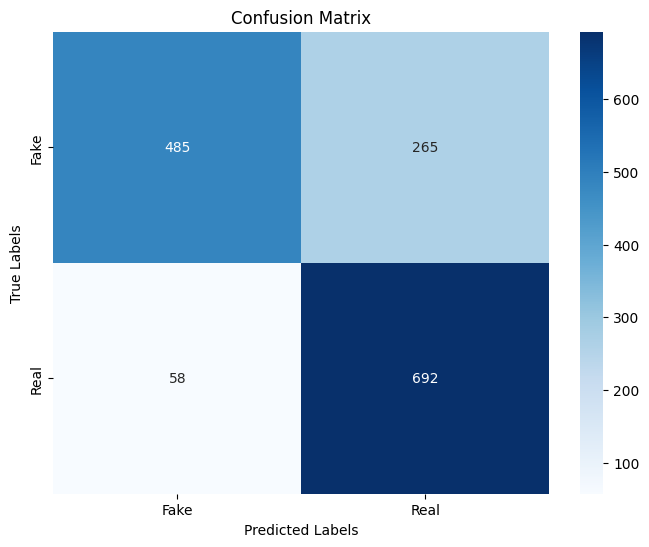

Accuracy: 0.7847
F1 Score: 0.7805
Precision: 0.7231
Recall: 0.9227
ROC AUC: 0.9037

Classification report:

              precision    recall  f1-score   support

        real     0.8932    0.6467    0.7502       750
        fake     0.7231    0.9227    0.8108       750

    accuracy                         0.7847      1500
   macro avg     0.8081    0.7847    0.7805      1500
weighted avg     0.8081    0.7847    0.7805      1500



In [23]:
cm = confusion_matrix(true_labels, predicted_classes)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Fake', 'Real'], yticklabels=['Fake', 'Real'])
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

# Calculate accuracy and F1 score
accuracy = accuracy_score(true_labels, predicted_classes)
f1 = f1_score(true_labels, predicted_classes, average='macro')
precision = precision_score(true_labels, predicted_classes)
recall = recall_score(true_labels, predicted_classes)
roc_auc = roc_auc_score(true_labels, predictions.predictions[:, 1])

# Display accuracy and F1 score
print(f"Accuracy: {accuracy:.4f}")
print(f"F1 Score: {f1:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"ROC AUC: {roc_auc:.4f}")
    
# Finally, display classification report
print()
print("Classification report:")
print()
print(classification_report(true_labels, predicted_classes, target_names=labels_list, digits=4))

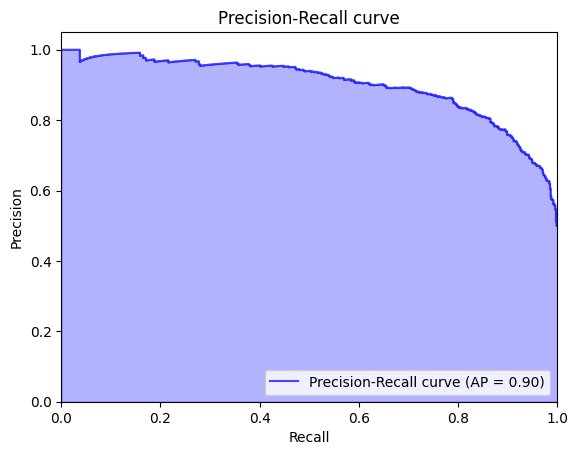

In [24]:
precision, recall, _ = precision_recall_curve(true_labels, predictions.predictions[:, 1])
average_precision = average_precision_score(true_labels, predictions.predictions[:, 1])

plt.figure()
plt.step(recall, precision, where='post', color='b', alpha=0.7, label='Precision-Recall curve (AP = %0.2f)' % average_precision)
plt.fill_between(recall, precision, step='post', alpha=0.3, color='b')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.ylim([0.0, 1.05])
plt.xlim([0.0, 1.0])
plt.title('Precision-Recall curve')
plt.legend(loc="lower right")
plt.show()

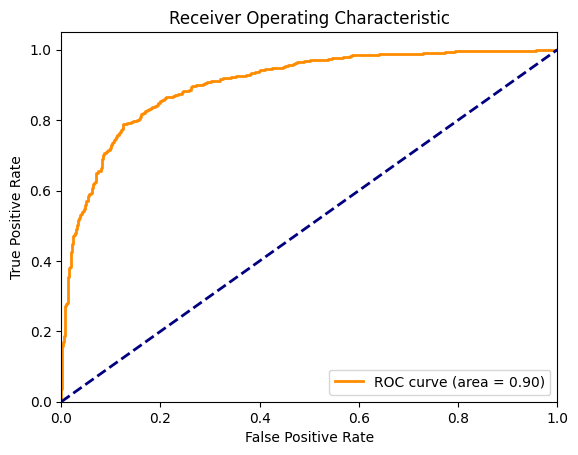

In [25]:
fpr, tpr, _ = roc_curve(true_labels, predictions.predictions[:, 1])
roc_auc = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()